In [1]:
import torch
import gym

## Markov Decision Process (MDP)
Markov chains(Probability matrices) are used to solve the Bellman Equation by finding the inverse of the probability/Markov matrix. 

The method is not scalable due to the computational complexity of calculating inverses of large matrices.

In [2]:
probs = torch.tensor([[[0.8, 0.1, 0.1], [0.1, 0.6, 0.3]], 
                     [[0.7, 0.2, 0.1], [.1, 0.8, 0.1]], 
                     [[0.6, 0.2, 0.2], [0.1, 0.4, 0.5]]])
   
reward = torch.tensor([1.0, 0.0, -1.0])
gamma = 0.5

action = 0

In [3]:
def mat_inverse(gamma, t_matrix, reward):
    inv = torch.inverse(torch.eye(reward.shape[0]) - gamma * t_matrix)    # (I - gamma*T)^-1
    return torch.matmul(inv, reward.reshape(-1, 1))                       # inv * reward

In [4]:
t_mat = probs[:, action]
V = mat_inverse(gamma, t_mat, reward)
print("Optimal policy value function: \n", V)

Optimal policy value function: 
 tensor([[ 1.6787],
        [ 0.6260],
        [-0.4820]])


## Policy Evaluation
Iteratively solve the Bellman Expectation equation approximately to an error threshold. As the threshold approaches 0, the solution converges to the optimal value.

Used to approximate the reward from a given policy.

In [5]:
thres = 0.0001
optimal_policy = torch.tensor([[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]])  # Action 1 always preferred (Optimal policy)

def policy_evaluation(policy, t_mat, gamma, reward, threshold):
    """
    policy: Policy to evaluate
    t_mat: transformation (probability) matrix
    reward: state rewards
    gamma: discount rate
    threshold: error threshold
    """
    num_states = policy.shape[0]
    V = torch.zeros(num_states)                                # Initialize to 0
    max_delta = threshold + 1
    count = 0
    while max_delta > threshold:
        temp = torch.zeros(num_states)                          
        for state, actions in enumerate(policy):
            for action, action_prob in enumerate(actions):
                temp[state] += action_prob * (reward[state] + gamma 
                * torch.dot(t_mat[state], V))                  # Update values based on Bellman eqn
        max_delta = torch.max(torch.abs(V - temp))             # Max change
        if (count % 20 == 0):
            print(max_delta)
        count += 1
        V = temp.clone()
    return V
                

In [6]:
V = policy_evaluation(optimal_policy, t_mat, gamma, reward, thres)
print("Optimal policy value function: \n", V)

tensor(1.)
Optimal policy value function: 
 tensor([ 1.6786,  0.6260, -0.4821])


# FrozenLake 
Reach the goal (G) from the start square (S) avoiding the holes (H).
4 movement directions: left(0), down(1), up(2) and right(3).

16 possible states:

0  1  2  3

4  5  6  7

8  9  10 11

12 13 14 15

This notebook works for both the 4x4 and 8x8 variants of FrozenLake. Just change the env name.


In [69]:
env = gym.make("FrozenLake-v0") 
# env = gym.make("FrozenLake8x8-v0")
num_states = env.observation_space.n
num_actions = env.action_space.n
num_states, num_actions

(64, 4)

In [70]:
env.reset()
print(env.reset())
env.render()

0

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [71]:
new_state, reward, is_done, info = env.step(1)
env.render()

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [72]:
print(new_state, reward, info)

1 0.0 {'prob': 0.3333333333333333}


In [73]:
def run_episode(env, policy):
    state = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done, info = env.step(action)
        total_reward += reward
    return total_reward

## Random Policy
Does not work since there's a probability the agent will not perform the action as specified.

In [75]:
NUM_EPISODES = 1000
total_reward = []
best_policy = None
for n in range(NUM_EPISODES):
    random_policy = torch.randint(high=num_actions, size=(num_states,))
    reward = run_episode(env, random_policy)
    total_reward.append(reward)
    if reward == 1:
        best_policy = random_policy

print(f"Success rate over {NUM_EPISODES} episodes: {sum(total_reward) * 100 / NUM_EPISODES}%")

total_reward = []
for n in range(NUM_EPISODES):
    total_reward.append(run_episode(env, best_policy))

print("Best policy", best_policy)
print(f"Success rate over {NUM_EPISODES} episodes: {sum(total_reward) * 100 / NUM_EPISODES}%")


Success rate over 1000 episodes: 0.1%
Best policy tensor([3, 2, 2, 1, 1, 0, 3, 1, 0, 0, 1, 2, 0, 1, 3, 0, 0, 0, 2, 1, 1, 2, 0, 2,
        1, 3, 1, 0, 3, 3, 0, 2, 0, 0, 1, 0, 3, 3, 2, 2, 3, 0, 2, 3, 0, 3, 3, 2,
        2, 1, 2, 2, 3, 2, 1, 1, 1, 0, 0, 3, 0, 2, 2, 2])
Success rate over 1000 episodes: 0.5%


In [35]:
from pprint import pprint
pprint(env.env.P)

{0: {0: [(0.3333333333333333, 0, 0.0, False),
         (0.3333333333333333, 0, 0.0, False),
         (0.3333333333333333, 4, 0.0, False)],
     1: [(0.3333333333333333, 0, 0.0, False),
         (0.3333333333333333, 4, 0.0, False),
         (0.3333333333333333, 1, 0.0, False)],
     2: [(0.3333333333333333, 4, 0.0, False),
         (0.3333333333333333, 1, 0.0, False),
         (0.3333333333333333, 0, 0.0, False)],
     3: [(0.3333333333333333, 1, 0.0, False),
         (0.3333333333333333, 0, 0.0, False),
         (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
         (0.3333333333333333, 0, 0.0, False),
         (0.3333333333333333, 5, 0.0, True)],
     1: [(0.3333333333333333, 0, 0.0, False),
         (0.3333333333333333, 5, 0.0, True),
         (0.3333333333333333, 2, 0.0, False)],
     2: [(0.3333333333333333, 5, 0.0, True),
         (0.3333333333333333, 2, 0.0, False),
         (0.3333333333333333, 1, 0.0, False)],
     3: [(0.3333333333333333,

## Value iteration
Pick action with the highest policy value instead of expected value(average). Better when there are fewer actions to choose from.

In [76]:
def value_iteration(env, gamma=0.99, thres = 0.0001):
    num_states, num_actions = env.observation_space.n, env.action_space.n
    V = torch.zeros(num_states)
    max_delta = thres + 1
    while max_delta > thres:
        temp = torch.zeros(num_states)
        for state in range(num_states):
            v_actions = torch.zeros(num_actions)
            for action in range(num_actions):
                for proba, new_state, reward, is_done in env.env.P[state][action]:
                    v_actions[action] += proba * (reward + gamma * V[new_state])    # Value iteration 
            temp[state] = torch.max(v_actions)              # Select the action with the highest reward
        max_delta = torch.max(torch.abs(V - temp))
        V = temp.clone()
    return V

In [77]:
optimal_values = value_iteration(env)
print("Optimal values:\n",  optimal_values)

Optimal values:
 tensor([0.4133, 0.4259, 0.4450, 0.4673, 0.4915, 0.5158, 0.5345, 0.5402, 0.4103,
        0.4199, 0.4363, 0.4573, 0.4823, 0.5127, 0.5450, 0.5567, 0.3953, 0.3925,
        0.3743, 0.0000, 0.4209, 0.4930, 0.5605, 0.5852, 0.3679, 0.3517, 0.3055,
        0.1998, 0.3001, 0.0000, 0.5684, 0.6277, 0.3306, 0.2899, 0.1965, 0.0000,
        0.2888, 0.3615, 0.5343, 0.6892, 0.3035, 0.0000, 0.0000, 0.0861, 0.2136,
        0.2724, 0.0000, 0.7717, 0.2859, 0.0000, 0.0571, 0.0472, 0.0000, 0.2504,
        0.0000, 0.8776, 0.2772, 0.1984, 0.1257, 0.0000, 0.2395, 0.4863, 0.7371,
        0.0000])


In [78]:
def extract_optimal_policy(env, V, gamma=0.99):
    num_states, num_actions = env.observation_space.n, env.action_space.n
    optimal_policy = torch.zeros(num_states)
    for state in range(num_states):
        v_actions = torch.zeros(num_actions)
        for action in range(num_actions):
            for proba, new_state, reward, _ in env.env.P[state][action]:
                v_actions[action] += proba * (reward + gamma * V[new_state])
        optimal_policy[state] = torch.argmax(v_actions)
    return optimal_policy

In [79]:
optimal_policy = extract_optimal_policy(env, optimal_values)
print("Optimal policy", optimal_policy)

Optimal policy tensor([3., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 2., 2., 1., 3., 3.,
        0., 0., 2., 3., 2., 1., 3., 3., 3., 1., 0., 0., 2., 2., 0., 3., 0., 0.,
        2., 1., 3., 2., 0., 0., 0., 1., 3., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
        0., 2., 0., 1., 0., 0., 1., 2., 1., 0.])


In [80]:
total_reward = []
for n in range(NUM_EPISODES):
    total_reward.append(run_episode(env, optimal_policy))
print(f"Success rate over {NUM_EPISODES} episodes: {sum(total_reward) * 100 / NUM_EPISODES}%")

Success rate over 1000 episodes: 87.3%


## Policy Iteration
Iteratively evaluate policies and improve them until the optimal policy is reached.
If there are a large number of actions, policy iteration converges faster. Also good when a good policy is already known (as a starting point).

In [81]:
def policy_evaluation(env, policy, gamma, threshold):
    num_states = env.observation_space.n
    V = torch.zeros(num_states)
    max_delta = threshold + 1
    while max_delta > threshold:
        temp = torch.zeros(num_states)
        for state in range(num_states):
            action = policy[state].item()
            for proba, new_state, reward, _ in env.env.P[state][action]:
                temp[state] += proba * (reward + V[new_state] * gamma)
        max_delta = torch.max(torch.abs(V - temp))
        V = temp.clone()
    return V

def policy_improvement(env, V, gamma):
    num_states, num_actions = env.observation_space.n, env.action_space.n
    policy = torch.zeros(num_states)
    for state in range(num_states):
        actions = torch.zeros(num_actions)
        for action in range(num_actions):
            for proba, new_state, reward, _ in env.env.P[state][action]:
                actions[action] += proba * (reward + V[new_state] * gamma)
        policy[state] = torch.argmax(actions)
    return policy

In [82]:
def policy_iteration(env, gamma=0.99, threshold=0.0001):
    num_states, num_actions = env.observation_space.n, env.action_space.n
    policy = torch.randint(high=num_actions, size=(num_states,)).float()
    while True:
        V = policy_evaluation(env, policy, gamma=gamma, threshold=threshold)
        new_policy = policy_improvement(env, V, gamma=gamma)
        if torch.equal(new_policy, policy):
            return V, new_policy
        policy = new_policy.clone()

In [83]:
V_optimal, optimal_policy = policy_iteration(env)
print("Optimal values:\n",  V_optimal)
print("Optimal policy", optimal_policy)

total_reward = []
for n in range(NUM_EPISODES):
    total_reward.append(run_episode(env, optimal_policy))
print(f"Success rate over {NUM_EPISODES} episodes: {sum(total_reward) * 100 / NUM_EPISODES}%")

Optimal values:
 tensor([0.4133, 0.4260, 0.4450, 0.4673, 0.4916, 0.5158, 0.5345, 0.5402, 0.4103,
        0.4199, 0.4363, 0.4573, 0.4823, 0.5128, 0.5451, 0.5567, 0.3954, 0.3925,
        0.3743, 0.0000, 0.4209, 0.4931, 0.5606, 0.5852, 0.3679, 0.3517, 0.3055,
        0.1998, 0.3001, 0.0000, 0.5684, 0.6277, 0.3306, 0.2900, 0.1965, 0.0000,
        0.2888, 0.3615, 0.5343, 0.6892, 0.3036, 0.0000, 0.0000, 0.0861, 0.2136,
        0.2724, 0.0000, 0.7717, 0.2859, 0.0000, 0.0571, 0.0472, 0.0000, 0.2504,
        0.0000, 0.8776, 0.2772, 0.1984, 0.1257, 0.0000, 0.2395, 0.4863, 0.7371,
        0.0000])
Optimal policy tensor([3., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 2., 2., 1., 3., 3.,
        0., 0., 2., 3., 2., 1., 3., 3., 3., 1., 0., 0., 2., 2., 0., 3., 0., 0.,
        2., 1., 3., 2., 0., 0., 0., 1., 3., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
        0., 2., 0., 1., 0., 0., 1., 2., 1., 0.])
Success rate over 1000 episodes: 84.3%


# The coin flipping gamble problem
Bet money on a coin flip landing on heads. But the coin is not balanced with a likelihood of heads being 40%. The goal is to reach $100.

In [153]:
max_capital = 100            # $100
num_states = max_capital + 1  # {0, 1, ..., 100}
gamma = 1                    # Undiscounted process, all previous actions matter
threshold = 0.0001 
rewards = torch.zeros(num_states)
rewards[-1] = 1              # Reward 1 if $100 is reached

head_prob = 0.4              # Probability of the coin landing on heads

In [154]:
env = {"max_capital": max_capital, "head_prob": head_prob,
       "rewards": rewards, "num_states": num_states}

In [155]:
def value_iteration(env, gamma, threshold):
    num_states = env["num_states"]
    head_prob = env["head_prob"]
    max_capital = env["max_capital"]
    rewards = env["rewards"]

    tail_prob = 1 - head_prob
    V = torch.zeros(num_states)
    max_delta = 1 + threshold
    while max_delta > threshold:
        temp = torch.zeros(num_states)
        # Game ends if the gambler runs out of money or reaches max_capital
        for state in range(1, max_capital):
            num_actions = min(state, max_capital - state) + 1
            actions = torch.zeros(num_actions)
            for action in range(1, num_actions):
                actions[action] += head_prob * (rewards[state + action] + gamma * V[state + action])+                                    tail_prob * (rewards[state - action] + gamma * V[state - action])
            temp[state] = torch.max(actions)
            
        max_delta = torch.max(torch.abs(V - temp))
        V = temp.clone()
    return V

def extract_optimal_policy(env, V, gamma):
    num_states = env["num_states"]
    head_prob = env["head_prob"]
    max_capital = env["max_capital"]
    rewards = env["rewards"]

    tail_prob = 1 - head_prob
    policy = torch.zeros(num_states)

    for state in range(num_states):
        num_actions = min(state, max_capital - state) + 1
        actions = torch.zeros(num_actions)
        for action in range(1, num_actions):
            actions[action] += head_prob * (rewards[state + action] + gamma * V[state + action]) +                                    tail_prob * (rewards[state - action] + gamma * V[state - action])
        policy[state] = torch.argmax(actions)
    return policy

In [156]:
import time

start = time.time()
optimal_values = value_iteration(env, gamma, threshold)
optimal_policy = extract_optimal_policy(env, optimal_values, gamma)
print("Time taken to obtain the optimal policy through value iteration: {:.3f}s".format(time.time() - start))
print("Optimal values:\n",  optimal_values)
print("Optimal policy", optimal_policy)

Time taken to obtain the optimal policy through value iteration: 3.956s
Optimal values:
 tensor([0.0000, 0.0021, 0.0052, 0.0092, 0.0129, 0.0174, 0.0231, 0.0278, 0.0323,
        0.0377, 0.0435, 0.0504, 0.0577, 0.0652, 0.0695, 0.0744, 0.0807, 0.0866,
        0.0942, 0.1031, 0.1087, 0.1160, 0.1259, 0.1336, 0.1441, 0.1600, 0.1631,
        0.1677, 0.1738, 0.1794, 0.1861, 0.1946, 0.2017, 0.2084, 0.2165, 0.2252,
        0.2355, 0.2465, 0.2579, 0.2643, 0.2716, 0.2810, 0.2899, 0.3013, 0.3147,
        0.3230, 0.3339, 0.3488, 0.3604, 0.3762, 0.4000, 0.4031, 0.4077, 0.4138,
        0.4194, 0.4261, 0.4346, 0.4417, 0.4484, 0.4565, 0.4652, 0.4755, 0.4865,
        0.4979, 0.5043, 0.5116, 0.5210, 0.5299, 0.5413, 0.5547, 0.5630, 0.5739,
        0.5888, 0.6004, 0.6162, 0.6400, 0.6446, 0.6516, 0.6608, 0.6690, 0.6791,
        0.6919, 0.7026, 0.7126, 0.7248, 0.7378, 0.7533, 0.7697, 0.7868, 0.7964,
        0.8075, 0.8215, 0.8349, 0.8520, 0.8721, 0.8845, 0.9009, 0.9232, 0.9405,
        0.9643, 0.0000])
Optima

Text(0, 0.5, 'Policy value/Bet')

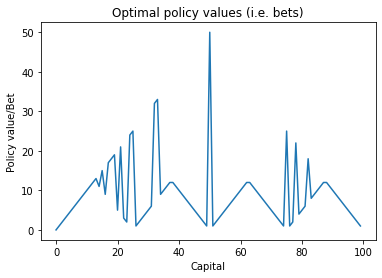

In [157]:
import matplotlib.pyplot as plt
plt.plot(optimal_policy[:100].numpy())
plt.title("Optimal policy values (i.e. bets)")
plt.xlabel("Capital")
plt.ylabel("Policy value/Bet")

### RESULT DOES NOT CONVERGE: HENCE INACCURATE

In [184]:
def policy_evaluation(env, policy, gamma, threshold):
    num_states = env["num_states"]
    head_prob = env["head_prob"]
    max_capital = env["max_capital"]
    rewards = env["rewards"]

    tail_prob = 1 - head_prob
    V = torch.zeros(num_states)
    max_delta = 1 + threshold
    while max_delta > threshold:
        temp = torch.zeros(num_states)
        # Game ends if the gambler runs out of money or reaches max_capital
        for state in range(1, max_capital):
            action = policy[state].item()
            temp[state] += head_prob * (rewards[state + action] + gamma * V[state + action])      
            temp[state] += tail_prob * (rewards[state - action] + gamma * V[state - action])          
        max_delta = torch.max(torch.abs(V - temp))
        V = temp.clone()
    return V

def policy_improvement(env, V, gamma):
    num_states = env["num_states"]
    head_prob = env["head_prob"]
    max_capital = env["max_capital"]
    rewards = env["rewards"]

    tail_prob = 1 - head_prob
    policy = torch.zeros(num_states).int()
    for state in range(1, max_capital):
        num_actions = min(state, max_capital - state) + 1
        actions = torch.zeros(num_actions)
        for action in range(1, num_actions):
            actions[action] += head_prob * (rewards[state + action] + gamma * V[state + action])
            actions[action] += tail_prob * (rewards[state - action] + gamma * V[state - action])
        policy[state] = torch.argmax(actions)
    return policy

In [204]:
def policy_iteration(env, gamma, threshold):
    num_states = env["num_states"]
    policy = torch.zeros(num_states).int()
    num_iterations = 0
    while True:
        V =  policy_evaluation(env, policy, gamma, threshold) # value_iteration(env, gamma, threshold)
        new_policy = policy_improvement(env, V, gamma)
        num_iterations += 1
        if torch.equal(new_policy, policy) or num_iterations == 50:
            return V, new_policy
        policy = new_policy

In [205]:
start = time.time()
optimal_values, optimal_policy = policy_iteration(env, 1, 0.0001)
print("Time taken to obtain the optimal policy through policy iteration: {:.3f}s".format(time.time() - start))
print("Optimal values:\n",  optimal_values)
print("Optimal policy", optimal_policy)

Time taken to obtain the optimal policy through policy iteration: 24.453s
Optimal values:
 tensor([0.0000, 0.0021, 0.0052, 0.0092, 0.0129, 0.0174, 0.0231, 0.0278, 0.0323,
        0.0377, 0.0435, 0.0503, 0.0576, 0.0652, 0.0695, 0.0744, 0.0807, 0.0866,
        0.0942, 0.1031, 0.1087, 0.1160, 0.1259, 0.1336, 0.1441, 0.1600, 0.1631,
        0.1677, 0.1738, 0.1794, 0.1861, 0.1946, 0.2017, 0.2084, 0.2165, 0.2252,
        0.2355, 0.2465, 0.2578, 0.2643, 0.2716, 0.2810, 0.2899, 0.3013, 0.3147,
        0.3230, 0.3339, 0.3488, 0.3604, 0.3762, 0.4000, 0.4031, 0.4077, 0.4138,
        0.4194, 0.4261, 0.4346, 0.4417, 0.4484, 0.4565, 0.4652, 0.4755, 0.4865,
        0.4978, 0.5043, 0.5116, 0.5210, 0.5299, 0.5413, 0.5547, 0.5630, 0.5739,
        0.5888, 0.6004, 0.6162, 0.6400, 0.6446, 0.6516, 0.6607, 0.6690, 0.6791,
        0.6919, 0.7025, 0.7126, 0.7248, 0.7378, 0.7533, 0.7697, 0.7868, 0.7964,
        0.8075, 0.8215, 0.8349, 0.8520, 0.8721, 0.8845, 0.9009, 0.9232, 0.9405,
        0.9643, 0.0000])
Opti

Text(0, 0.5, 'Policy value/Bet')

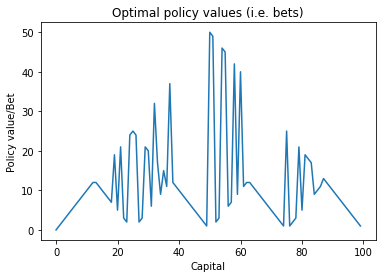

In [206]:
plt.plot(optimal_policy[:100].numpy())
plt.title("Optimal policy values (i.e. bets)")
plt.xlabel("Capital")
plt.ylabel("Policy value/Bet")